<h1>Circular Plate in Cartesian Coordinates</h1>

In [220]:
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse.linalg import eigsh
from scipy.linalg import eig
import itertools

<h1>2D Circle - Eigenvalue Problem in Cartesian Co-ordinates</h1>

The solution for the circle is almost identical to the square solution with one main difference.

We still use a square grid in x and y but this time we relate the x and y coordinates to polar coordinates r and theta. 

We can plot a circle in polar coordinates on the same square grid we used previously. If we know the radius of the circle we can use a simple calculation to determine what grid points are inside/outside the circle.

The for loops which generates our matrix will iterate over grid points inside the circle, and on the edge of the circle instead of all grid points. 

<p>After eliminating the Time Dependence from the 2D Wave Equation using separation of variables, we arrive at the Helmholtz Equation. 
<br><br>
We solve this as an eigenvalue problem of the following form for the set of eigenmodes on a cartesian (x,y) plane:</p>
<p>$$\nabla^2z(x,y) = -s^2z(x,y)$$</p>
<p>
The CDA (Central Difference Approximation) was used to discretise the derivative terms in the Laplacian.
<br><br>
$$\frac{\partial^2 z(x_i,y_j)}{\partial x^2} = \frac{z(x_{i+1},y_j)-2z(x_i,y_j)+z(x_{i-1},y_j)}{\Delta{x^2}}$$
    <br>
$$\frac{\partial^2 z(x_i,y_j)}{\partial y^2} = \frac{z(x_{i},y_{j+1})-2z(x_i,y_j)+z(x_{i},y_{j-1})}{\Delta{y^2}}$$
<br><br>
A Dirichlet condition was imposed on the system at the edge of the circle (where r is greater than or equal to r_boundary).
    
This could be done using a boolean mask in which a square grid is constructed and points falling within a radius are labelled as True, while all others are labelled False. False points are then automatically equated to 0. 
    
As the grid is a square, typical Cartesian finite difference could be implemented, and a Tridiagonal matrix formed.
    
We obtain the following formulae to use in our triadiagonal matrix:
    
For the Interior points -
</p>
<p>
$$z(x_i,y_j): -2\frac{1}{(\Delta{x})^2} - 2\frac{1}{(\Delta{y})^2}$$
<br>
$$z(x_{i+1},y_j): \frac{1}{(\Delta{x})^2}$$
<br>
$$z(x_{i-1},y_j): \frac{1}{(\Delta{x})^2}$$
<br>
$$z(x_{i},y_{j+1}): \frac{1}{(\Delta{y})^2}$$
<br>
$$z(x_{i},y_{j-1}): \frac{1}{(\Delta{y})^2}$$
</p>
<br><br>
<p>
We solve the tridiagonal matrix for its eigenvectors/eigenvalues and display the first 6 modes graphically.
</p>
<br><br>

In [248]:
# Boundary Circle

# import time
# start_time = time.time()

# theta goes from 0 to 2pi
theta = np.linspace(0, 2*np.pi, 101)

# the radius of the circle

x_origin = 0
y_origin = 0

r_boundary = np.sqrt(0.6)

# Compute x and y: ALL of x and y are inside the boundary 
x_boundary = r_boundary*np.cos(theta)
y_boundary = r_boundary*np.sin(theta)

Nx_boundary = np.size(x_boundary)
Ny_boundary = np.size(y_boundary)

# Make x,y grid 
x_upper_lim = 1.0
x_lower_lim = -1.0

y_upper_lim = 1.0
y_lower_lim = -1.0

# Number of grid points

Nx = 50
Ny = 50

x = np.linspace(x_lower_lim,x_upper_lim,Nx) # Mesh
y = np.linspace(y_lower_lim,y_upper_lim,Ny)

dx = x[1] - x[0] # Mesh Size
dy = y[1] - y[0]

# Create Meshgrid: 

X, Y = np.meshgrid(x, y) # X is size x^2, Y is size y^2

# Define general r values from X and Y

r = np.sqrt((X - x_origin)**2 + (Y - y_origin)**2)

dr = 0.25

# Define grid points that are inside/outside the circle - returns boolean matrix 

outside = r > r_boundary

inside = r < r_boundary

on = np.copy(r)

on = (on != 0)

for i in range(Nx):
    for j in range(Ny):
        if (r_boundary-dr < on[i][j] < r_boundary+dr):
            on[i][j] = True
        else:
            on[i][j] = False
            

# Initialise matrices

N = Nx*Ny # no. of unknowns

M = np.zeros((N,N)) # N rows, N columns
M.astype(float)

# Boundaries 

# Points defined by X[outside], Y[outside]
# Using Dirichlet conditions where z = 0 outside the circle, our zeroes matrix already meets this condition

x_outside = X[outside]
y_outside = Y[outside]

# Interiors

x_inside = X[inside]
y_inside = Y[inside]

x_on = X[on]
y_on = Y[on]

# Want to say:
# For the x_inside points and y_inside points of X and Y 

for i in range(0,Nx):
    for j in range(0,Ny):
        if inside[i][j] == True:
            n = i+j*Nx
            M[n,n] = -2*((1/(dx)**2) + (1/(dy)**2)) # Main diagonal
            M[n,n-1]=1/((dx)**2) # Off diagonal to the left ie. point i-1, j
            M[n,n+1]=1/((dx)**2) # Off diagonal to the right ie. point i+1, j
            M[n,n-Nx]=1/((dy)**2) # Far off diagonal to the left ie. point i, j-1
            M[n,n+Nx]=1/((dy)**2) # Far off diagonal to the left ie. point i, j+1
        if ((x_on[i] == True) and (y_on[j] == True)):
            n = i+j*Nx
            M[n,n] = -2*((1/(dx)**2) + (1/(dy)**2)) 
            M[n,n-1]=0 
            M[n,n+1]=2/((dx)**2) 
            M[n,n-Nx]=0 
            M[n,n+Nx]=2/((dy)**2) 
            
            
# Solve for z
alpha,z = eig(M)

alpha = np.real(alpha)
z = np.real(z)

# print("--- %s seconds ---" % (time.time() - start_time))

# print('E-value:', alpha)

In [249]:
# Function which returns the reshaped eigenvector which corresponds to whatever eigenmode is inputted
def get_eigenvector(arr, eigenstate):
    index = np.argwhere((abs(arr)==np.sort(abs(arr))[eigenstate]) & (np.round(np.sort(abs(arr))[eigenstate], 6)!=0))
    if index.size>0:
        return np.reshape(z[:,index[0]], (Nx,Ny))

In [250]:
# Function which returns the reshaped eigenvector which corresponds to whatever eigenmode is inputted
def get_eigenvalue(eigenstate):
    index = np.argwhere((abs(alpha)==np.sort(abs(alpha))[eigenstate]) & (np.round(np.sort(abs(alpha))[eigenstate], 6)!=0))
    if index.size>0:
        return alpha[index]

In [251]:
# Returns first non-zero element of array
sorted_alpha = np.sort(abs(alpha))
first_nonzero = next((i for i, x in enumerate(sorted_alpha) if x), None)

z_num = 0
for i in range((first_nonzero+100)):
    eigenvector = get_eigenvector(alpha, i)
    eigenvalue = get_eigenvalue(i)
    if eigenvector is not None:
        globals()["z_" + str(z_num)] = eigenvector
        globals()["alpha_" + str(z_num)] = eigenvalue
        s_squared = abs(eigenvalue)
        frequency = np.sqrt(s_squared * 330**2)/(2*np.pi)
        globals()["freq_" + str(z_num)] = frequency
        z_num += 1

In [252]:
def z_range(z):
    
    z_max_val = np.max(z)
#     z_min = np.min(z) 

    z_min = z_max_val*-0.4
    z_max = z_max_val*0.4
    
    Z = z.copy()
    Z[z<z_min] = np.nan
    Z[z>z_max] = np.nan
    
    return Z

In [253]:
# ax = plt.contourf(z_0, cmap='magma')
# cb = plt.colorbar(ax)

# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# ax.plot_surface(X, Y, z_14, cmap='summer', linewidth=0, antialiased=False)
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('z')
# ax.set_zlim3d((-0.075, 0.075))
# ax.set_zlim3d((-0.07, 0.07))
# ax.view_init(18, 42)
# ax.set_title('Circular 2-D Helmholtz')

# plt.imshow(z_range(z_14), cmap='gray')
# plt.axis('off')

print(freq_5/freq_14)
print(freq_5/freq_29)
print(freq_14/freq_29)

[[0.6401498]]
[[0.47222926]]
[[0.73768555]]


In [254]:
plt.imshow(z_range(z_14), cmap='gray')
plt.axis('off')

(-0.5, 49.5, 49.5, -0.5)

Text(0.5, 0.92, 'Circular 2-D Helmholtz')

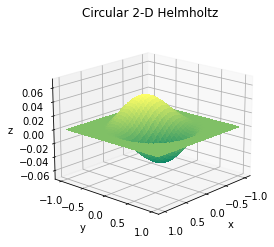

In [6]:
ax = plt.contourf(z_1, cmap='magma')
cb = plt.colorbar(ax)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X, Y, z_1, cmap='summer', linewidth=0, antialiased=False)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_zlim3d((-0.075, 0.075))
ax.set_zlim3d((-0.07, 0.07))
ax.view_init(18, 42)
ax.set_title('Circular 2-D Helmholtz')

Text(0.5, 0.92, 'Circular 2-D Helmholtz')

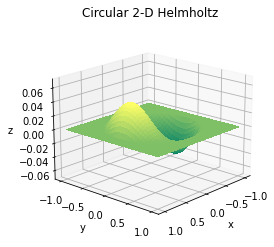

In [7]:
ax = plt.contourf(z_2, cmap='magma')
cb = plt.colorbar(ax)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X, Y, z_2, cmap='summer', linewidth=0, antialiased=False)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_zlim3d((-0.075, 0.075))
ax.set_zlim3d((-0.07, 0.07))
ax.view_init(18, 42)
ax.set_title('Circular 2-D Helmholtz')

Text(0.5, 0.92, 'Circular 2-D Helmholtz')

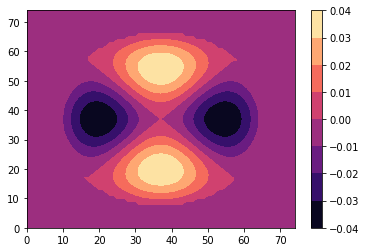

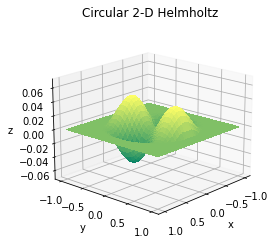

In [8]:
ax = plt.contourf(z_3, cmap='magma')
cb = plt.colorbar(ax)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X, Y, z_3, cmap='summer', linewidth=0, antialiased=False)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_zlim3d((-0.075, 0.075))
ax.set_zlim3d((-0.07, 0.07))
ax.view_init(18, 42)
ax.set_title('Circular 2-D Helmholtz')

Text(0.5, 0.92, 'Circular 2-D Helmholtz')

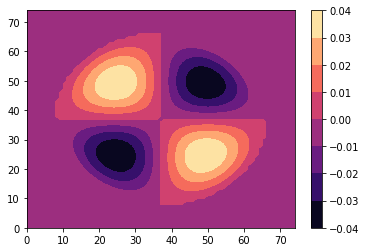

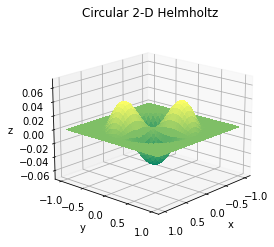

In [9]:
ax = plt.contourf(z_4, cmap='magma')
cb = plt.colorbar(ax)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X, Y, z_4, cmap='summer', linewidth=0, antialiased=False)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_zlim3d((-0.075, 0.075))
ax.set_zlim3d((-0.07, 0.07))
ax.view_init(18, 42)
ax.set_title('Circular 2-D Helmholtz')

Text(0.5, 0.92, 'Circular 2-D Helmholtz')

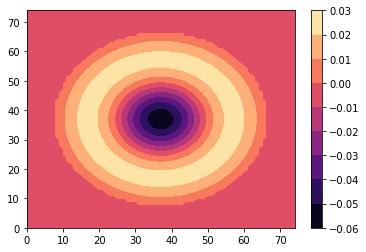

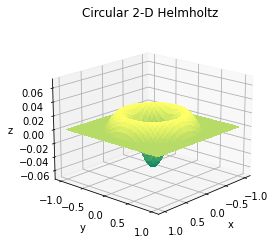

In [10]:
ax = plt.contourf(z_5, cmap='magma')
cb = plt.colorbar(ax)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X, Y, z_5, cmap='summer', linewidth=0, antialiased=False)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_zlim3d((-0.075, 0.075))
ax.set_zlim3d((-0.07, 0.07))
ax.view_init(18, 42)
ax.set_title('Circular 2-D Helmholtz')

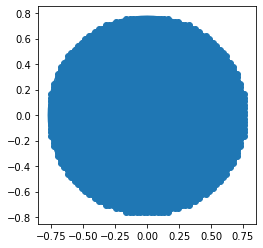

In [11]:
# create the figure
fig, ax = plt.subplots(1)
ax.plot(x_boundary, y_boundary)
ax.set_aspect(1)
# plt.plot(X, Y, marker='.', color='k', linestyle='none')
# ax.scatter(X[outside], Y[outside])
ax.scatter(X[inside], Y[inside])
plt.show()